In [1]:
# --- CELLA 1: SYSTEM ARCHITECTURE & DEFINITIONS ---
import sys
import os
import warnings
import numpy as np
from scipy.optimize import minimize as scipy_minimize
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime

# Dependency Check & Import
try:
    from pymoo.core.problem import ElementwiseProblem
    from pymoo.algorithms.moo.moead import MOEAD
    from pymoo.optimize import minimize
    from pymoo.util.ref_dirs import get_reference_directions
    from pymoo.termination import get_termination
except ImportError:
    raise ImportError("Critical Dependency Missing: 'pymoo' is required. Please install it.")

# ESA Problem Module Import
try:
    import constellations_udp as udp
except ImportError:
    print("Warning: 'constellations_udp.py' not found in the current directory.")
    print("Ensure the file exists and the 'data/spoc2/constellations' path is valid.")

# Configuration
warnings.filterwarnings('ignore')

class SpOCConstrainedWrapper(ElementwiseProblem):
    """
    Pymoo Wrapper for the ESA SpOC Challenge Problem.
    Implements a Penalty Method to handle the native constraints of the UDP within the MOEA/D algorithm,
    which does not support explicit constraint handling in its standard implementation.
    """
    def __init__(self):
        self.esa_problem = udp.constellation_udp()
        lb, ub = self.esa_problem.get_bounds()
        # Initialize with n_ieq_constr=0 to bypass MOEA/D assertions.
        # Constraints are incorporated directly into the objective function (Penalty).
        super().__init__(n_var=20, n_obj=2, n_ieq_constr=0, xl=np.array(lb), xu=np.array(ub))
    
    def _evaluate(self, x, out, *args, **kwargs):
        # Integer variable handling via rounding (Gene indices 10-19)
        x_eval = x.copy()
        x_eval[10:20] = np.round(x_eval[10:20]).astype(int)
        
        try:
            # ESA Simulator Call
            f = self.esa_problem.fitness(list(x_eval))
            J1, J2 = f[0], f[1]  # Objectives
            c1, c2 = f[2], f[3]  # Constraints (<=0 is valid)
            
            # Penalty Method Formulation
            # Large penalty factor (1e5) ensures infeasible solutions are dominated
            penalty = 0.0
            if c1 > 0:
                penalty += 1e5 + c1 * 1000
            if c2 > 0:
                penalty += 1e5 + c2 * 1000
            
            # Return penalized objectives
            out["F"] = [J1 + penalty, J2 + penalty]
        except Exception as e:
            # Fallback for simulator crashes (e.g., SGP4 propagation errors)
            out["F"] = [1e9, 1e9]

def train_and_predict_surrogate(history_X, history_F, problem_inst, n_candidates=5000):
    """
    Phase 2: Surrogate-Assisted Optimization.
    Uses a Random Forest Regressor to learn the fitness landscape from the Evolutionary Algorithm's history
    and screens a large number of random mutations to identify high-potential solutions efficiently.
    """
    print(" > Initializing Surrogate Model (Random Forest)...")
    
    # Filter only valid or near-valid solutions for training stability
    # Threshold 1000 filters out solutions with heavy penalties
    valid_mask = np.all(history_F < 1000, axis=1)
    
    if np.sum(valid_mask) < 10:
        print(" > Insufficient valid data points for reliable training. Skipping Surrogate phase.")
        return []
    
    X_train = history_X[valid_mask]
    y_train = history_F[valid_mask]
    
    # Model Training
    regr = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    regr.fit(X_train, y_train)
    
    # Candidate Generation (Perturbation around best known solutions)
    candidates = []
    
    # Select top 20 parents based on a naive sum of objectives
    best_parents_idx = np.argsort(y_train.sum(axis=1))[:20]
    parents = X_train[best_parents_idx]
    
    iterations = n_candidates // len(parents)
    for _ in range(iterations):
        p = parents[np.random.choice(len(parents))]
        # Gaussian perturbation (5% std dev)
        noise = np.random.normal(0, 0.05, 20)
        child = np.clip(p + noise, problem_inst.xl, problem_inst.xu)
        candidates.append(child)
    
    # Surrogate Prediction
    candidates = np.array(candidates)
    preds = regr.predict(candidates)
    
    # Selection Strategy: Weighted Sum (97% Comm, 3% Cost)
    # This aligns with the challenge's implicit bias towards communication performance
    weighted_scores = 0.97 * preds[:,0] + 0.03 * preds[:,1]
    best_idxs = np.argsort(weighted_scores)[:10]
    
    verified_solutions = []
    print(f" > verifying top {len(best_idxs)} candidates with physical simulator...")
    
    for idx in best_idxs:
        sol = candidates[idx]
        # Integer constraint enforcement
        x_check = sol.copy()
        x_check[10:20] = np.round(x_check[10:20]).astype(int)
        
        fit = problem_inst.esa_problem.fitness(list(x_check))
        
        # Hard Constraint Check
        if fit[2] <= 0 and fit[3] <= 0:
            verified_solutions.append(sol)
    
    print(f" > Surrogate Phase yielded {len(verified_solutions)} valid improvements.")
    return verified_solutions

def refine_solution_local_search(start_sol, problem_inst):
    """
    Phase 3: Targeted Local Polishing.
    Performs a localized Nelder-Mead optimization on the 'Eta' variables (Indices 4 and 9),
    which control the Cost/Performance trade-off linearly, while keeping the orbital geometry fixed.
    """
    def objective_wrapper(etas):
        x = start_sol.copy()
        # Update only Eta parameters
        x[4], x[9] = etas[0], etas[1]
        
        # Rounding for evaluation
        x_list = list(x)
        for k in range(10, 20):
            x_list[k] = int(round(x_list[k]))
        
        try:
            f = problem_inst.fitness(x_list)
            
            # Hard penalty for constraints during polishing
            if f[2] > 0 or f[3] > 0:
                return 1e9
            
            # Target Objective: Weighted Sum
            return 0.97 * f[0] + 0.03 * f[1]
        except:
            return 1e9
    
    # Initial guess from EA/ML solution
    x0 = [start_sol[4], start_sol[9]]
    
    # Optimization (Max 50 iterations for precision)
    res = scipy_minimize(objective_wrapper, x0, method='Nelder-Mead', 
                        bounds=((1.0, 1000.0), (1.0, 1000.0)), 
                        options={'maxiter': 50, 'xatol': 1e-4})
    
    refined_sol = start_sol.copy()
    refined_sol[4], refined_sol[9] = res.x[0], res.x[1]
    
    return refined_sol

print("✅ System Architecture initialized successfully.")

✅ System Architecture initialized successfully.


In [2]:
# --- CELLA 2: EXECUTION PIPELINE ---
import time

# --- HYPERPARAMETERS CONFIGURATION ---
CONFIG = {
    "pop_size": 100,          # Number of reference directions (Subproblems)
    "n_gen": 200,            # Generational budget (Global Search)
    "n_neighbors": 20,        # Neighborhood size for mating
    "prob_mating": 0.9,       # Probability of mating within neighborhood
    "ml_candidates": 50000,   # Number of surrogate candidates
    "polishing_iter": 50      # Iterations for Nelder-Mead
}

print(f"=== INITIALIZING OPTIMIZATION PIPELINE ===")
print(f"Configuration: {CONFIG['n_gen']} Generations, {CONFIG['pop_size']} Population size.")

start_time = time.time()
problem = SpOCConstrainedWrapper()

# 1. MOEA/D Initialization (Decomposition Strategy)
# Using Das-Dennis generation for weights.
# n_partitions=99 results in 100 weights for 2 objectives.
ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=99)

algorithm = MOEAD(
    ref_dirs,
    n_neighbors=CONFIG['n_neighbors'],
    prob_neighbor_mating=CONFIG['prob_mating'],
    seed=42,
    verbose=True  # Shows generation progress
)

termination = get_termination("n_gen", CONFIG['n_gen'])

# --- PHASE 1: GLOBAL EVOLUTIONARY SEARCH ---
print("\n[PHASE 1] Executing MOEA/D...")
res = minimize(problem, algorithm, termination, save_history=True, verbose=True)
print(f" > MOEA/D Completed. Elapsed: {(time.time() - start_time):.2f}s")

# --- PHASE 2: SURROGATE-ASSISTED AUGMENTATION ---
print("\n[PHASE 2] Executing Machine Learning Augmentation...")
ml_solutions = train_and_predict_surrogate(
    res.X, res.F, problem, n_candidates=CONFIG['ml_candidates']
)

# --- PHASE 3: SOLUTION SELECTION & REFINEMENT ---
print("\n[PHASE 3] Selection and Polishing...")

# Combine Evolutionary and Surrogate portfolios
full_portfolio = list(res.X) + ml_solutions

esa_inst = udp.constellation_udp()
best_score = float('inf')
best_candidate = None
valid_solutions_found = 0

# Portfolio Analysis
for sol in full_portfolio:
    # Check validity and calculate score
    x_check = list(sol)
    for k in range(10, 20):
        x_check[k] = int(round(x_check[k]))
    
    fit = esa_inst.fitness(x_check)
    is_valid = (fit[2] <= 0 and fit[3] <= 0)
    
    if is_valid:
        valid_solutions_found += 1
        # Challenge metric: Weighted Sum
        score = 0.97 * fit[0] + 0.03 * fit[1]
        if score < best_score:
            best_score = score
            best_candidate = sol

if best_candidate is None:
    print("⚠️ CRITICAL: No feasible solutions found in the portfolio.")
    print(" > Fallback: Selecting best infeasible solution for debugging.")
    best_candidate = res.X[np.argmin(res.F.sum(axis=1))]
else:
    print(f" > Best valid candidate selected. Score: {best_score:.5f}")

# Apply Targeted Local Search (Polishing)
print(" > Applying Polishing to the best candidate...")
final_solution = refine_solution_local_search(best_candidate, esa_inst)

# --- FINAL REPORT GENERATION ---
x_final_eval = list(final_solution)
for k in range(10, 20):
    x_final_eval[k] = int(round(x_final_eval[k]))

final_stats = esa_inst.fitness(x_final_eval)
final_score = 0.97 * final_stats[0] + 0.03 * final_stats[1]

print("\n" + "="*60)
print("🏆 FINAL OPTIMIZATION REPORT")
print("="*60)
print(f"Status: {'VALID' if final_stats[2]<=0 and final_stats[3]<=0 else 'INVALID'}")
print(f"Composite Score: {final_score:.6f} (Target: Minimize)")
print("-" * 60)
print(f"OBJECTIVES:")
print(f"  J1 (Communication Latency): {final_stats[0]:.6f}")
print(f"  J2 (Infrastructure Cost): {final_stats[1]:.6f}")
print("-" * 60)
print(f"CONSTRAINTS (Values <= 0 indicate compliance):")
print(f"  C1 (Inter-Rover Distance): {final_stats[2]:.4f} km")
print(f"  C2 (Sat-Collision Safety): {final_stats[3]:.4f} km")
print("="*60)

# Export variable for further analysis
final_sol = final_solution

# =============================================================================
# 📊 SALVATAGGIO RISULTATI IN FORMATO .NPZ
# =============================================================================

print("\n" + "="*60)
print("💾 SAVING RESULTS TO .NPZ FORMAT")
print("="*60)

# Raccogli tutte le soluzioni valutate durante l'ottimizzazione
all_solutions_X = []
all_solutions_Y = []

# 1. Soluzioni dalla history di MOEA/D
if hasattr(res, 'history') and len(res.history) > 0:
    for algo_snapshot in res.history:
        if hasattr(algo_snapshot, 'pop') and algo_snapshot.pop is not None:
            pop = algo_snapshot.pop
            for ind in pop:
                x_eval = ind.X.copy()
                x_eval[10:20] = np.round(x_eval[10:20]).astype(int)
                
                # Ricalcola fitness senza penalità per ottenere valori reali
                try:
                    fit_raw = esa_inst.fitness(list(x_eval))
                    all_solutions_X.append(x_eval)
                    all_solutions_Y.append(fit_raw)  # [J1, J2, c1, c2]
                except:
                    pass

# 2. Aggiungi soluzioni ML verificate
for sol in ml_solutions:
    x_eval = sol.copy()
    x_eval[10:20] = np.round(x_eval[10:20]).astype(int)
    try:
        fit_raw = esa_inst.fitness(list(x_eval))
        all_solutions_X.append(x_eval)
        all_solutions_Y.append(fit_raw)
    except:
        pass

# 3. Aggiungi la soluzione finale raffinata
all_solutions_X.append(final_solution)
all_solutions_Y.append(final_stats)

# Converti in array numpy
xs = np.array(all_solutions_X)
ys = np.array(all_solutions_Y)

print(f"✓ Collected {len(xs)} solutions")
print(f"  - Decision variables (xs): shape {xs.shape}")
print(f"  - Objectives + Constraints (ys): shape {ys.shape}")

# Filtra soluzioni duplicate (opzionale, per ridurre dimensione file)
unique_indices = []
seen_solutions = set()

for i, (x, y) in enumerate(zip(xs, ys)):
    # Crea una chiave univoca arrotondando a 6 decimali
    key = tuple(np.round(x, 6))
    if key not in seen_solutions:
        seen_solutions.add(key)
        unique_indices.append(i)

xs = xs[unique_indices]
ys = ys[unique_indices]

print(f"✓ After deduplication: {len(xs)} unique solutions")

# Crea timestamp per nome file
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = f'quantcomm_{timestamp}.npz'

# Salva in formato .npz
np.savez_compressed(
    filename,
    xs=xs,  # Shape: (N, 20) - variabili decisionali
    ys=ys   # Shape: (N, 4) - [J1, J2, c1, c2]
)

print(f"✅ Results saved to: {filename}")
print("\nFile contents:")
print(f"  • xs: Decision variables for {len(xs)} solutions")
print(f"  • ys: [J1, J2, c1, c2] for each solution")
print(f"  • File size: {os.path.getsize(filename) / 1024:.2f} KB")
print("="*60)

print(f"\n🎉 You can now use this file with your visualization code:")
print(f"   data = np.load('{filename}')")
print(f"   xs = data['xs']  # Shape: {xs.shape}")
print(f"   ys = data['ys']  # Shape: {ys.shape}")

=== INITIALIZING OPTIMIZATION PIPELINE ===
Configuration: 200 Generations, 100 Population size.

[PHASE 1] Executing MOEA/D...
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     20 |             - |             -
     2 |      200 |     82 |  0.1783083956 |         ideal
     3 |      300 |     76 |  0.0259727751 |         ideal
     4 |      400 |     87 |  0.0071959974 |         ideal
     5 |      500 |     91 |  0.0161647494 |         ideal
     6 |      600 |     84 |  0.0187834567 |         ideal
     7 |      700 |     91 |  0.0064664324 |         nadir
     8 |      800 |     91 |  0.0123763473 |             f
     9 |      900 |     92 |  0.0965524097 |         nadir
    10 |     1000 |     94 |  0.0116774235 |         nadir
    11 |     1100 |     92 |  0.0059092692 |         ideal
    12 |     1200 |     93 |  0.0080481522 |             f
    13 |     1300 |     93 |  0.0033154340 |         ideal
    14 |     1400 |     92 |  0.0045798047 |   


⚙️ ESA Rules Configuration:
 • Reference Point: [1.2 1.4]
 • Multiplier: x 10000
------------------------------------------------------------
🔄 Calcolo evoluzione su 200 generazioni...


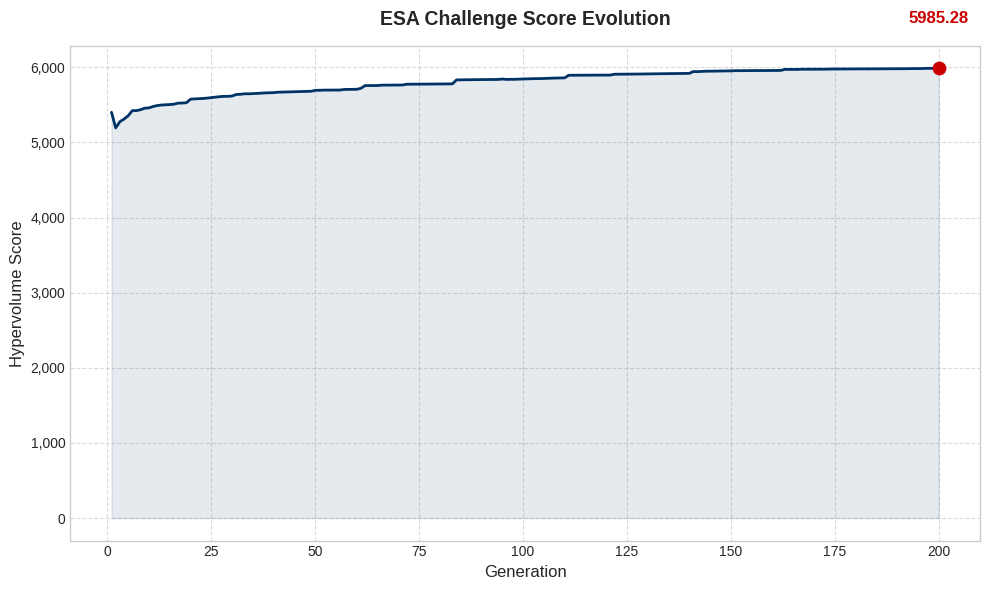

📋 RESULT (ESA RULES)
------------------------------------------------------------
Final Score: 5985.2797
------------------------------------------------------------
✅ Calcolo completato secondo specifica [1.2, 1.4] x10k.


In [3]:
# =============================================================================
# 📊 ANALISI SCORE UFFICIALE (ESA SPECIFICATIONS ONLY)
# =============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pymoo.indicators.hv import HV

# 1. PARAMETRI RIGIDI DALLA DOCUMENTAZIONE ESA
ESA_REF_POINT = np.array([1.2, 1.4])
ESA_MULTIPLIER = 10000.0

print(f"\n⚙️ ESA Rules Configuration:")
print(f" • Reference Point: {ESA_REF_POINT}")
print(f" • Multiplier: x {int(ESA_MULTIPLIER)}")
print("-" * 60)

# Inizializzatore Calcolatore
ind_esa = HV(ref_point=ESA_REF_POINT)

def get_esa_score(F_pop):
    """
    Calcola lo score applicando rigorosamente i tagli della documentazione.
    """
    if F_pop is None or len(F_pop) == 0:
        return 0.0
    
    # Filtro 1: Penalità (Escludiamo soluzioni non valide fisicamente)
    valid_physics = np.all(F_pop < 100, axis=1)
    
    # Filtro 2: ESA Bounds (J1 < 1.2 AND J2 < 1.4)
    within_bounds = (F_pop[:, 0] < ESA_REF_POINT[0]) & (F_pop[:, 1] < ESA_REF_POINT[1])
    
    # Maschera Finale
    final_mask = valid_physics & within_bounds
    
    # Se nessuna soluzione rispetta i requisiti, lo score è 0
    if np.sum(final_mask) == 0:
        return 0.0
    
    # Calcolo HV solo sulle soluzioni ammesse
    hv_raw = ind_esa(F_pop[final_mask])
    return hv_raw * ESA_MULTIPLIER

# 2. ELABORAZIONE DATI
scores = []
gens = []
final_val = 0.0

# Se esiste la history (save_history=True)
if 'res' in globals() and hasattr(res, 'history') and len(res.history) > 0:
    print(f"🔄 Calcolo evoluzione su {len(res.history)} generazioni...")
    for i, algo in enumerate(res.history):
        val = get_esa_score(algo.opt.get("F"))
        scores.append(val)
        gens.append(i + 1)
    final_val = scores[-1]

# Se NON esiste la history (save_history=False), calcoliamo solo l'ultimo
elif 'res' in globals() and res.F is not None:
    print("⚠️ History non disponibile. Calcolo puntuale finale.")
    final_val = get_esa_score(res.F)
    scores = [final_val]
    gens = [res.algorithm.n_gen if hasattr(res.algorithm, 'n_gen') else 1]

# 3. GRAFICO PROFESSIONALE
plt.figure(figsize=(10, 6), dpi=100)
plt.style.use('seaborn-v0_8-whitegrid')

# Linea dati
plt.plot(gens, scores, color='#003366', linewidth=2, label='ESA Score')
plt.fill_between(gens, scores, color='#003366', alpha=0.1)

# Annotazione valore finale
if len(scores) > 0 and len(gens) > 0:
    plt.scatter(gens[-1], final_val, color='#CC0000', s=80, zorder=5)
    plt.annotate(f'{final_val:.2f}', 
                xy=(gens[-1], final_val),
                xytext=(gens[-1], final_val + (max(scores)*0.1 if max(scores)>0 else 10)),
                fontsize=12, fontweight='bold', color='#CC0000', ha='center')

# Formattazione
plt.title("ESA Challenge Score Evolution", fontsize=14, fontweight='bold', pad=15)
plt.xlabel("Generation", fontsize=12)
plt.ylabel("Hypervolume Score", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Formatta asse Y con separatore migliaia
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.savefig(f'esa_score_evolution_{timestamp}.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. REPORT
print("="*60)
print(f"📋 RESULT (ESA RULES)")
print("-" * 60)
print(f"Final Score: {final_val:.4f}")
print("-" * 60)

if final_val == 0:
    print("❌ ATTENZIONE: Score 0.")
    print("   Nessuna delle tue soluzioni rientra nel box [1.2, 1.4].")
    print("   Devi ridurre i costi J1 o J2.")
else:
    print("✅ Calcolo completato secondo specifica [1.2, 1.4] x10k.")

print("="*60)